In [2]:
import pandas
import numpy

In [3]:
# Read the data
df = pandas.read_csv('sales_data.csv')
df.head()

,sales,date
0,112,2022-08-21
1,118,2022-08-22
2,132,2022-08-23
3,129,2022-08-24
4,121,2022-08-25


In [4]:
# date to datetime object
df['date'] = pandas.to_datetime(df['date'])

# date to index
df.set_index('date', inplace=True)


In [5]:
# general info about the data
df.info()

# check if there are any missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2022-08-21 to 2023-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


sales    0
dtype: int64

<AxesSubplot:xlabel='date'>

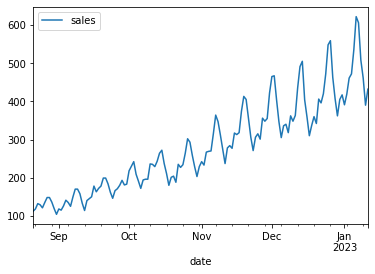

In [6]:
# plot the sales in a line chart
df.plot()

In [7]:
# create lagged features with 5 days lag
def create_lags():
    for i in range(1, 6):
        df['lag_' + str(i)] = df['sales'].shift(i)
    return df

df = create_lags()

# create rolling mean with 5, 10, 15, 20 days window
def create_rolling_mean():
    for i in [5, 10, 15, 20]:
        df['rolling_mean_' + str(i)] = df['sales'].shift().rolling(window=i).mean()
    return df

df = create_rolling_mean()

In [8]:
# drop na
df.dropna(inplace=True)

In [9]:
# split the data into train and test with in-built function
from sklearn.model_selection import train_test_split

X = df.drop('sales', axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [10]:
# create a dataframe with ds and y and add x_train columns on ds
df_train = pandas.DataFrame({'ds': X_train.index, 'y': y_train})
df_train = df_train.merge(X_train, left_on='ds', right_index=True)

df_train

,ds,y,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_5,rolling_mean_10,rolling_mean_15,rolling_mean_20
date,,,,,,,,,,,
2022-09-10,2022-09-10,158,170.0,170.0,149.0,125.0,135.0,149.8,135.3,135.933333,132.55
2022-09-11,2022-09-11,133,158.0,170.0,170.0,149.0,125.0,154.4,140.7,137.466667,134.85
2022-09-12,2022-09-12,114,133.0,158.0,170.0,170.0,149.0,156.0,142.2,136.466667,135.60
2022-09-13,2022-09-13,140,114.0,133.0,158.0,170.0,170.0,149.0,142.1,134.200000,134.70
2022-09-14,2022-09-14,145,140.0,114.0,133.0,158.0,170.0,143.0,143.5,134.466667,135.25
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-13,2022-12-13,491,435.0,363.0,348.0,362.0,318.0,365.2,355.8,374.333333,358.20
2022-12-14,2022-12-14,505,491.0,435.0,363.0,348.0,362.0,399.8,364.5,383.866667,369.20
2022-12-15,2022-12-15,404,505.0,491.0,435.0,363.0,348.0,428.4,380.3,393.866667,379.15


/home/olli/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
15:39:55 - cmdstanpy - INFO - Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing


23.714793441339943


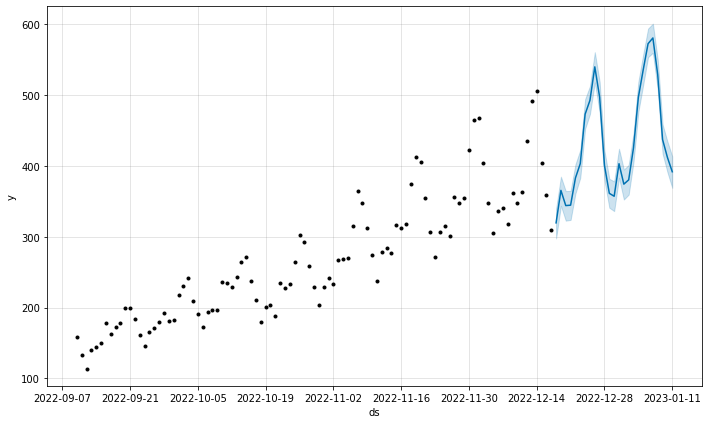

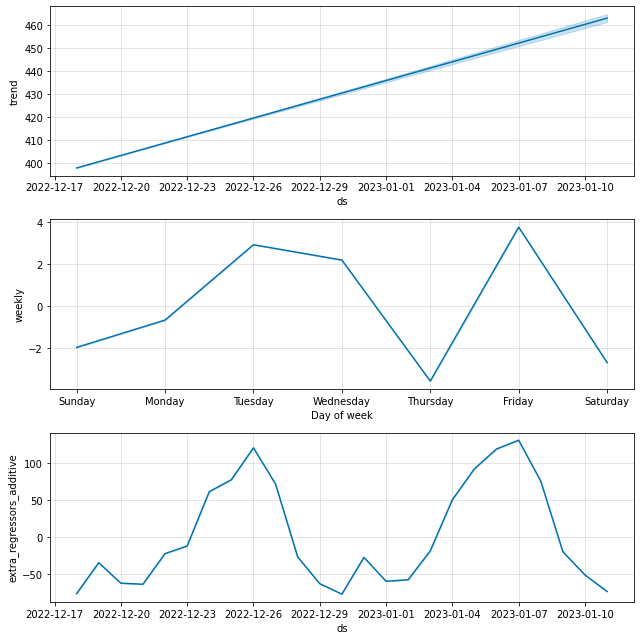

In [11]:
# prophet
from prophet import Prophet

# create a new Prophet object
model = Prophet()
model.add_regressor('lag_1')
model.add_regressor('lag_2')
model.add_regressor('lag_3')
model.add_regressor('lag_4')
model.add_regressor('lag_5')
model.add_regressor('rolling_mean_5')
model.add_regressor('rolling_mean_10')
model.add_regressor('rolling_mean_15')
model.add_regressor('rolling_mean_20')

# fit the model
model.fit(df_train)

# create a new dataframe with the dates for which we want to make predictions
future = model.make_future_dataframe(periods=29, freq='D', include_history=False)

# add the regressors to the future dataframe
future = future.merge(X_test, left_on='ds', right_index=True)

# make predictions
forecast = model.predict(future)

# plot the predictions
model.plot(forecast)

# plot the components
model.plot_components(forecast)

# mae
from sklearn.metrics import mean_absolute_error

# get the predictions
predictions = forecast['yhat'].values

# get the actual values
actual = y_test.values

# calculate the mae
mae = mean_absolute_error(actual, predictions)

# print the mae
print(mae)

15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing


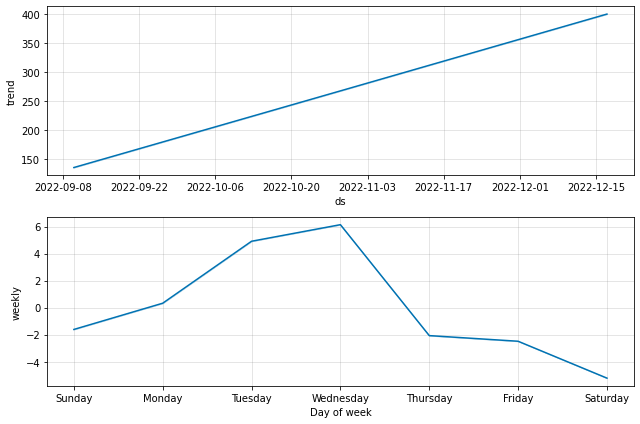

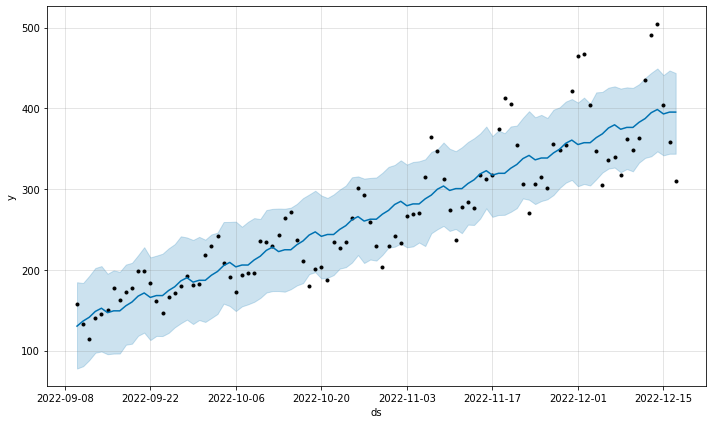

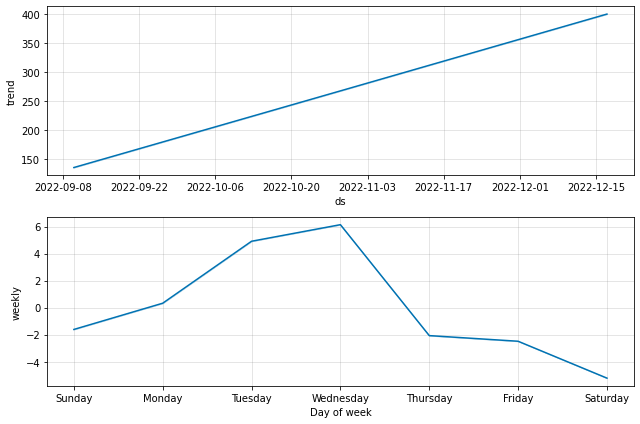

In [16]:
# Prophet with the whole dataset and 29 days forecast
# prophet
from prophet import Prophet

# create a new Prophet object
model = Prophet()

# create a dataframe with ds and y and add x_train columns on ds
df_whole = pandas.DataFrame({'ds': X.index, 'y': y})
df_whole = df_train.merge(X, left_on='ds', right_index=True)

# fit the model
model.fit(df_whole)

# create a new dataframe with the dates for which we want to make predictions
future = model.make_future_dataframe(periods=60, freq='D', include_history=True)

# add the regressors to the future dataframe
future = future.merge(df_whole, left_on='ds', right_index=True)

# make predictions
forecast = model.predict(future)

# plot the predictions
model.plot(forecast)

# plot the components
model.plot_components(forecast)